In [26]:
import os
import tarfile
import requests
import pandas as pd
from pathlib import Path
from typing import Optional, Dict
from pydantic import BaseModel, ConfigDict
import matplotlib.pyplot as plt


class MovieDataset(BaseModel):
    """Class to handle downloading, extracting, and loading the CMU Movie Dataset.

    Attributes:
        base_url (str): URL for downloading the dataset.
        dataset_filename (str): Name of the dataset archive file.
        download_dir (Path): Directory where dataset will be downloaded.
        extracted_dir (Path): Directory where dataset will be extracted.
        dataset_path (Path): Full path to the downloaded archive.
        dataframes (Dict[str, Optional[pd.DataFrame]]): Dictionary holding all loaded DataFrames.
    """

    base_url: str = "http://www.cs.cmu.edu/~ark/personas/data/"
    dataset_filename: str = "MovieSummaries.tar.gz"
    download_dir: Path = Path("downloads")
    extracted_dir: Path = download_dir / "MovieSummaries"
    dataset_path: Path = download_dir / dataset_filename

    # Dictionary to store all dynamically loaded datasets
    dataframes: Dict[str, Optional[pd.DataFrame]] = {}

    model_config = ConfigDict(arbitrary_types_allowed=True, extra="allow") 

    column_names: object = {
        "movie_metadata": [
            "wiki_movie_id", "freebase_movie_id", "movie_name", "release_date",
            "box_office_revenue", "runtime", "languages", "countries", "genres"
        ],
        "character_metadata": [
            "wiki_movie_id", "freebase_movie_id", "release_date", "character_name",
            "actor_dob", "actor_gender", "actor_height", "actor_ethnicity",
            "actor_name", "actor_age_at_release", "freebase_char_actor_map_id",
            "freebase_char_id", "freebase_actor_id"
        ],
        "plot_summaries": ["wiki_movie_id", "plot_summary"],
        "tvtropes_clusters": ["freebase_char_actor_map_id", "tvtrope_cluster"],
        "name_clusters": ["freebase_char_actor_map_id", "character_name"]
    }

    def __init__(self):
        """
        Initializes the MovieDataset class.
        - Creates necessary directories.
        - Downloads dataset if missing.
        - Extracts dataset if needed.
        - Dynamically loads all .tsv and .txt files into Pandas DataFrames.
        """

        super().__init__()

        # Ensure the download directory exists
        self.download_dir.mkdir(exist_ok=True)

        # Download dataset if it does not exist
        if not self.dataset_path.exists():
            self.download_dataset()

        # Extract dataset if it has not been extracted
        if not self.extracted_dir.exists():
            self.extract_dataset()

        # Load all available dataset files dynamically
        self.load_all_datasets()

    def download_dataset(self):
        """Downloads the dataset from the specified URL if it does not already exist."""
        print(f"Downloading {self.dataset_filename}...")

        try:
            response = requests.get(self.base_url + self.dataset_filename, stream=True)
            response.raise_for_status()

            with open(self.dataset_path, "wb") as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)

            print("Download complete.")

        except requests.exceptions.RequestException as e:
            print(f"Download failed: {e}")

    def extract_dataset(self):
        """Extracts the dataset archive into the designated directory."""
        print("Extracting dataset...")

        try:
            with tarfile.open(self.dataset_path, "r:gz") as tar:
                tar.extractall(path=self.download_dir)
            print("Extraction complete.")
        except tarfile.TarError as e:
            print(f"Error extracting dataset: {e}")

    def load_all_datasets(self):
        """
        Dynamically loads all .tsv and .txt files from the extracted directory into Pandas DataFrames.
        - Each dataset is stored in a dictionary (dataframes) using the filename (without extension) as the key.
        """

        if not self.extracted_dir.exists():
            print(f"Error: Extracted directory {self.extracted_dir} does not exist.")
            return

        for file_path in self.extracted_dir.glob("*"):
            if file_path.suffix in [".tsv", ".txt"]:  # Load only relevant file types
                self.load_dataset(file_path, sep="\t")
        
    def load_dataset(self, file_path: Path, sep: str = "\t"):
        """
        Loads a dataset file into a Pandas DataFrame and stores it in dataframes.

        Args:
            file_path (Path): Path to the dataset file.
            sep (str): Separator used in the file (default is tab-separated).
        """
        dataset_name = file_path.stem.replace('.', '_') # Extract filename without extension

        print(f"Checking file: {file_path}")  # Debugging line

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)

            # Apply column names if recognized
            if dataset_name in self.column_names:
                df.columns = self.column_names[dataset_name]

            setattr(self, dataset_name, df)  # Dynamically set as attribute
            print(f"Loaded dataset: {dataset_name}, Shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            setattr(self, dataset_name, None)
    
    def movie_type(self, N: int = 10) -> pd.DataFrame:
        """
        Returns a DataFrame with the N most common movie types (genres) and their counts.
        """
        if not isinstance(N, int):
            raise Exception("N must be an integer.")
        
        if not hasattr(self, "movie_metadata") or self.movie_metadata is None:
            raise Exception("Movie metadata is not loaded.")
        
        # Extract genres from the last column, which is a dictionary
        genre_series = self.movie_metadata["genres"].dropna()
        
        # Convert each genre dictionary into a list of genres and flatten
        genre_list = genre_series.apply(lambda x: list(eval(x).values()))  # Assuming it's stored as a stringified dictionary
        genre_flattened = [genre for sublist in genre_list for genre in sublist]

        # Count the occurrence of each genre
        genre_counts = pd.Series(genre_flattened).value_counts()
        
        # Create DataFrame with the top N genres
        result_df = genre_counts.head(N).reset_index()
        result_df.columns = ["Movie_Type", "Count"]
        
        return result_df

    def actor_count(self) -> pd.DataFrame:
        """
        Returns a histogram DataFrame showing the number of actors per movie vs. the movie count.
        Also, displays a histogram plot.
        
        The output DataFrame will have:
        - "Number_of_Actors" (unique actor count per movie)
        - "Movie_Count" (number of movies with that many actors)
        """
        if not hasattr(self, "character_metadata") or self.character_metadata is None:
            raise Exception("Character metadata is not loaded.")

        # Ensure required columns exist
        required_columns = {"wiki_movie_id", "actor_name"}
        if not required_columns.issubset(self.character_metadata.columns):
            raise Exception(f"Missing required columns: {required_columns - set(self.character_metadata.columns)}")

        # Count the number of unique actors per movie
        actor_counts = self.character_metadata.groupby("wiki_movie_id")["actor_name"].nunique()

        # Create a histogram DataFrame: How many movies have X number of actors?
        histogram = actor_counts.value_counts().reset_index()
        histogram.columns = ["Number_of_Actors", "Movie_Count"]

        # Sort the results in ascending order of number of actors
        histogram = histogram.sort_values(by="Number_of_Actors")

        # --- PLOT THE HISTOGRAM ---
        plt.figure(figsize=(10, 6))
        plt.bar(histogram["Number_of_Actors"], histogram["Movie_Count"], color="skyblue", edgecolor="black")
        plt.xlabel("Number of Actors per Movie")
        plt.ylabel("Movie Count")
        plt.title("Histogram of Number of Actors per Movie")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        
        # Show the plot
        plt.show()

        return histogram



In [27]:
test_data = MovieDataset()


Checking file: downloads/MovieSummaries/plot_summaries.txt
Loaded dataset: plot_summaries, Shape: (42303, 2)
Checking file: downloads/MovieSummaries/movie.metadata.tsv
Loaded dataset: movie_metadata, Shape: (81741, 9)
Checking file: downloads/MovieSummaries/name.clusters.txt
Loaded dataset: name_clusters, Shape: (2666, 2)
Checking file: downloads/MovieSummaries/README.txt
Loaded dataset: README, Shape: (52, 1)
Checking file: downloads/MovieSummaries/character.metadata.tsv
Loaded dataset: character_metadata, Shape: (450669, 13)
Checking file: downloads/MovieSummaries/tvtropes.clusters.txt
Loaded dataset: tvtropes_clusters, Shape: (501, 2)


In [28]:
test_data.movie_metadata.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [29]:
test_data.movie_type(5)

,Movie_Type,Count
0,Drama,34007
1,Comedy,16349
2,Romance Film,10234
3,Black-and-white,9094
4,Action,8798


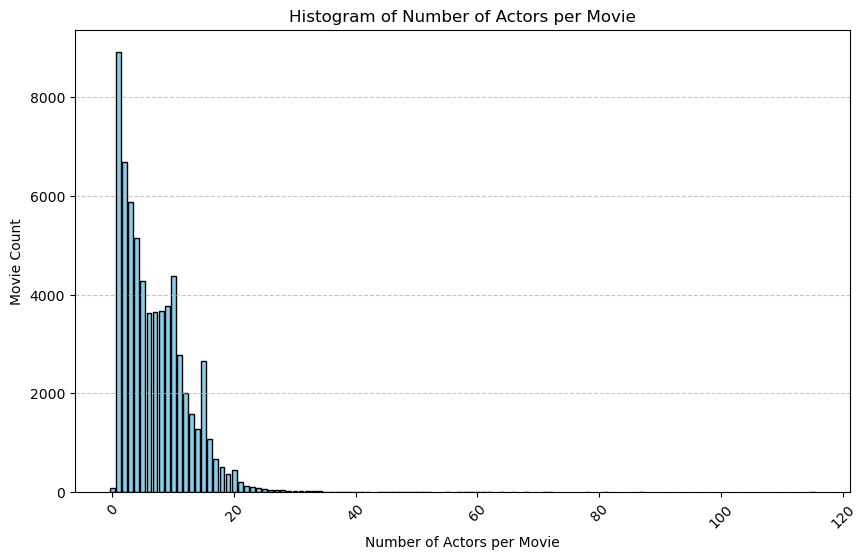

,Number_of_Actors,Movie_Count
24,0,72
0,1,8921
1,2,6699
2,3,5874
3,4,5159
...,...,...
57,72,1
53,78,1
60,81,1
52,87,1


In [30]:
test_data.actor_count()